<h1>0. Packages</h1>

In [1]:
import numpy as np
import re
import skyfield.sgp4lib as spg4
import matplotlib.pyplot as plt
import random
from scipy.stats import uniform
%matplotlib inline

<h1>1. Data Structure</h1>

<h3>1.1 Satellite Structure</h3>

Creating an object to represent satellite from 3le.txt <br>
May end up using implementation from another package

<b>Data sources:<b><br>
https://www.space-track.org    
https://www.celestrak.com/NORAD/documentation/spacetrk.pdf

<b>Information about 3le/2le:</b><br>
https://en.wikipedia.org/wiki/Two-line_element_set#cite_note-nasahelp-12
https://spaceflight.nasa.gov/realdata/sightings/SSapplications/Post/JavaSSOP/SSOP_Help/tle_def.html

In [2]:
class two_line_element:
    
    def __init__(self, data):
        self.parse_data(data)
        
    def parse_data(self, satelite_data):
        self.title = satelite_data[0]
        line_one = satelite_data[1].split()
        line_two = satelite_data[2].split()

        self.catalog_number = re.search('[0-9]{1,5}', line_one[0]).group()
        self.classification = re.search('[UCS]', line_one[0]).group()

        international_designator = re.search('([0-9]{2})([0-9]{3})(\w{1,3})', line_one[1])
        self.launch_year = international_designator.group(1)
        self.launch_number = international_designator.group(2)
        self.launch_piece =  international_designator.group(3)

        epoch = re.search('([0-9]{2})(\d+\.\d+)', line_one[2])
        self.epoch_year = epoch.group(1)
        self.epoch_day = epoch.group(2)

        self.ballistic_coefficient = float(line_one[3])
        self.mean_motion_double_prime = line_one[4]
        self.BSTAR = line_one[5]

        self.inclination = line_two[1]
        self.right_ascension_of_ascending_node = line_two[2]
        self.eccentricity = line_two[3]
        self.argument_of_perigee = line_two[4]

        mean_anomaly = line_two[5]

<h3>Data structure implementation using spg4 from skyfield library<h3>

In [3]:
# Opening the .txt file
with open("3le.txt") as f:
    txt = f.read()
    
sat_lines = re.findall('(.*?)\n(.*?)\n(.*?)\n', txt)

# Preview of `sat_lines`, each element should be the three lines representing a satellite
print(sat_lines[0])

# Convert each group of 3 lines into a satelite object
def line_element_to_satellite(lines):
    title = lines[0]
    line1 = lines[1]
    line2 = lines[2]
    return spg4.EarthSatellite(line1, line2, name=title)

satellites = [line_element_to_satellite(lines) for lines in sat_lines]

# Verify data structure by finding element representing the ISS
iss_index = [sat.name for sat in satellites].index("0 ISS (ZARYA)")
iss = satellites[iss_index]

('0 VANGUARD 1', '1     5U 58002B   19352.86539842  .00000184  00000-0  20948-3 0  9994', '2     5  34.2610  67.7117 1845282 255.2293  83.7559 10.84789954185624')


<h3>1.2 Celestial Bodies</h3>


de421.bsp is a Ephemerides provided by JPL Horizon which has the calculated positions of celestial bodies within a certain time interval. de421 is commonly used due to its small size and its relativley up to date information

In [ ]:
from skyfield.api import load, EarthSatellite

# Loading the data from de421.bsp using skyfield 
planets = load('de421.bsp')

# Finding the data about Earth
earth = planets["Earth"]

<h3>1.3 Celestial Bodies</h3>

Plotting the satellite data in a 3D view.<br>
Accidently broke my implementation so need to start with the below base and get it to plot the ISS again.

<b>Source:</b> https://space.stackexchange.com/questions/25958/how-can-i-plot-a-satellites-orbit-in-3d-from-a-tle-using-python-and-skyfield

In [ ]:
def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 
    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)
            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw

def deriv(X, t):
    x, v = X.reshape(2, -1)
    acc = -GMe * x * ((x**2).sum())**-1.5
    return np.hstack((v, acc))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint as ODEint
from mpl_toolkits.mplot3d import Axes3D

halfpi, pi, twopi = [f*np.pi for f in (0.5, 1, 2)]
degs, rads = 180/pi, pi/180

km  = 0.001
GMe = 3.986E+14 # m^3/s^2
Re  = 6378137.  # meters
alt = 1e6     # meters
a   = Re + alt
T   = twopi * np.sqrt(a**3/GMe)

v0  = np.sqrt(GMe/a)
incdegs = 57.

inc = rads * incdegs
cinc, sinc = [f(inc) for f in (np.cos, np.sin)]

X0 = np.array([Re+alt, 0, 0] + [0, cinc*v0, sinc*v0])

print("period {} seconds or {} minutes".format(T, T/60))
print("inclination {} degrees".format(incdegs))
print("initial position {} km".format(km * X0[:3]))
print("initial velocity {} m/s".format(X0[3:]))
print("initial speed {} m/s".format(v0))

times = np.linspace(0, T, 201)

answer, info = ODEint(deriv, X0, times, full_output=True)


theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
lon0 = Re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)

lat0 = Re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in (np.cos, np.sin)]
    lat = Re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)

if True:
    fig = plt.figure(figsize=[10, 8])  # [12, 10]

    ax  = fig.add_subplot(1, 1, 1, projection='3d')

    x, y, z = answer.T[:3]
    ax.plot(km*x, km*y, km*z)
    for x, y, z in lons:
        ax.plot(km*x, km*y, km*z, '-k')
    for x, y, z in lats:
        ax.plot(km*x, km*y, km*z, '-k')

    centers, hw = makecubelimits(ax)

    print("centers are: ", centers)
    print("hw is:       ", hw)
    plt.show()

<h1>2. Breakup Models</h1>

<h3>2.1 NASA breakup model</h3>

<b>Implementation:</b> (Found on page 207)<br>
https://www.researchgate.net/publication/295490674_Space_debris_cloud_evolution_in_Low_Earth_Orbit

<b>Alternate implementation:</b><br>
https://gitlab.obspm.fr/apetit/nasa-breakup-model/tree/master

<b>Information:</b><br>
https://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?referer=https://en.wikipedia.org/&httpsredir=1&article=1094&context=theses

In [57]:
from enum import Enum     # for enum34, or the stdlib version
from scipy.stats import norm
import scipy.stats as stats
debris_category = Enum('Category', 'rb sc soc')

""" ----------------- Mean ----------------- """


"""
Mean functions for Area to mass ratio
"""
def RB_mean_AM(lambda_c):
    mean_am_1 = mean_am_2 = None
    # Area1 rule
    if lambda_c <= -0.5:
        mean_am_1 = -0.45
    elif (lambda_c > -0.5 and lambda_c < 0):
        mean_am_1 = -0.45 - (0.9*(lambda_c + 0.5))
    else:
        mean_am_1 = -0.9
    # Area2 rule
    mean_am_2 = -0.9
    return (mean_am_1, mean_am_2)

RB_mean_AM = np.vectorize(RB_mean_AM)

def SC_mean_AM(lambda_c):
    mean_am_1 = mean_am_2 = None
    # Area1 rule
    if lambda_c <= -1.1:
        mean_am_1 = -0.6
    elif (lambda_c > -1.1 and lambda_c < 0):
        mean_am_1 = -0.6 - (0.318*(lambda_c +1.1))
    else:
        mean_am_1 = -0.95
    # Area2 rule
    if lambda_c <= -0.7:
        mean_am_2 = -1.2
    elif (lambda_c > -0.7 and lambda_c < -0.1):
        mean_am_2 = -1.2 - (1.333*(lambda_c + 0.7))
    else:
        mean_am_2 = -2.0
    return (mean_am_1, mean_am_2)

SC_mean_AM = np.vectorize(SC_mean_AM)

def SOC_mean_AM(lambda_c):
    mean_am_1 = mean_am_2 = None
    if lambda_c <= -1.75: 
        mean_am_1 = -0.3
    elif -1.75 < lambda_c and lambda_c < -1.25:
        mean_am_1 = -0.3 - (1.4*(lambda_c + 1.75))
    else:
        mean_am_1 = -1.0
    return (mean_am_1, 0)
SOC_mean_AM = np.vectorize(SOC_mean_AM)

def mean_AM(lambda_c, debris_type):    
    if debris_type == debris_category.rb:
        return RB_mean_AM(lambda_c)
    elif debris_type == debris_category.sc:
        return SC_mean_AM(lambda_c)
    else:
        return SOC_mean_AM(lambda_c)
    
"""
Mean functions for ∆V
"""

def mean_deltaV(kai, explosion):    
    if explosion == True:
        return (0.2 * kai) + 1.85
    else:
        # Is a collision
        return (0.9 * kai) + 2.9
        
    
mean_deltaV = np.vectorize(mean_deltaV)

""" ----------------- Standard Deviation ----------------- """
def RB_std_dev_AM(lambda_c):
    std_dev_1 = std_dev_2 = None
    # dev1 rule
    std_dev_1 = 0.55
    # dev2 rule
    if lambda_c <= -1.0:
        std_dev_2 = 0.28
    elif (lambda_c > -1.0 and lambda_c < 0.1):
        std_dev_2 = 0.28 - (0.1636*(lambda_c + 1))
    else:
        std_dev_2 = 0.1
    return (std_dev_1, std_dev_2)
RB_std_dev_AM = np.vectorize(RB_std_dev_AM)

def SC_std_dev_AM(lambda_c):
    std_dev_1 = std_dev_2 = None
    # dev1 rule
    if lambda_c <= -1.3:
        std_dev_1 = 0.1
    elif (lambda_c > -1.3 and lambda_c < -0.3):
        std_dev_1 = 0.1 + (0.2*(lambda_c + 1.3))
    else:
        std_dev_1 = 0.3
    # dev2 rule
    if lambda_c <= -0.5:
        std_dev_2 = 0.5
    elif (lambda_c > -0.5 and lambda_c < -0.3):
        std_dev_2 = 0.5 - (lambda_c + 0.5)
    else:
        std_dev_2 = 0.3
    return (std_dev_1, std_dev_2)
SC_std_dev_AM = np.vectorize(SC_std_dev_AM)

def SOC_std_dev_AM(lambda_c):
    std_dev_1 = std_dev_2 = None
    if lambda_c <= -3.5:
        std_dev_1 =  0.2
    else:
        std_dev_1 = 0.2 + (0.1333*(lambda_c + 3.5))
    return (std_dev_1, 0)
SOC_std_dev_AM = np.vectorize(SOC_std_dev_AM)

def std_dev_AM(lambda_c, debris_type):
    if debris_type == debris_category.rb:
        return RB_std_dev_AM(lambda_c)
    elif debris_type == debris_category.sc:
        return SC_std_dev_AM(lambda_c)
    else:
        return SOC_std_dev_AM(lambda_c)
std_dev_AM = np.vectorize(std_dev_AM)  

def std_dev_deltaV():
    return 0.4
std_dev_deltaV = np.vectorize(std_dev_deltaV)   

""" ----------------- Alpha ----------------- """
def alpha_AM(lambda_c, debris_type):
    def RB_alpha_AM(lambda_c):
        alpha = 1
        # dev1 rule
        if lambda_c <= -1.4:
            alpha = 1
        elif (lambda_c > -1.4 and lambda_c < 0):
            alpha = 1 - (0.3571*(lambda_c + 1.4))
        else:
            alpha = 0.5
        return alpha
    
    def SC_alpha_AM(lambda_c):
        alpha = 1
        # dev1 rule
        if lambda_c <= -1.95:
            alpha = 0
        elif (lambda_c > -1.95 and lambda_c < 0.55):
            alpha = 0.3 + (0.4*(lambda_c + 1.2))
        else:
            alpha = 1
        return alpha
    
    def SOC_alpha_AM(lambda_c):
        # Is not used by SOC, for saftey returning 1
        alpha = 1
        return alpha
        
    if debris_type == debris_category.rb:
        return RB_alpha_AM(lambda_c)
    elif debris_type == debris_category.sc:
        return SC_alpha_AM(lambda_c)
    else:
        return SOC_alpha_AM(lambda_c)    

alpha_AM = np.vectorize(alpha_AM)

    
""" ----------------- Distribution ----------------- """
## This returns Kai, thus to get A/M get rid of returned log10
def distribution_AM(N_fragments, lambda_c, debris_type):
    
    mean_preSwitch = np.array(mean_AM(lambda_c, debris_type)) # This takes a long time
    std_dev_preSwitch = np.array(std_dev_AM(lambda_c, debris_type)) # This takes a long time
    alpha = np.array(alpha_AM(lambda_c, debris_category.rb)) # This takes a long time
    switch = np.random.uniform(0,1, N_fragments)
    
    if debris_type == debris_category.rb or debris_type == debris_category.sc:
    
        means = np.empty(N_fragments)
        I,J = switch<alpha, switch>=alpha
        means[I] = mean_preSwitch[0, I] 
        means[J] = mean_preSwitch[1, J]

        devs = np.empty(N_fragments)
        devs[I] = std_dev_preSwitch[0, I] 
        devs[J] = std_dev_preSwitch[1, J] 
        
        return np.random.normal(means, devs, N_fragments)
    
    else:
        means = mean_preSwitch[0]
        devs = std_dev_preSwitch[0]
        
        return np.random.normal(means, devs, N_fragments)
    
def distribution_deltaV(N_fragments, kai, v_c, explosion=True):
    
    mean = mean_deltaV(kai, explosion)
    dev = std_dev_deltaV()
    
    distribution = np.random.lognormal(mean, dev, N_fragments)
    non_valid_vel = np.nonzero(distribution <= (1.3 * v_c))[0]
    for i in non_valid_vel:
        print(int(i / len(non_valid_vel)), "%")
        while distribution[i] > (1.3 * v_c):
            distribution[i] = np.random.lognormal(mean[i], dev, 1)
    return distribution
    
""" ----------------- Area ----------------- """
def avg_area(L_c):
    if L_c < 0.00167: #(m)
        return 0.540424 * L_c**2
    else:
        return 0.556945 * L_c**2.0047077
avg_area = np.vectorize(avg_area)

""" ----------------- Num. Fragments ----------------- """
def number_fragments(l_characteristic, m_target, m_projectile, v_impact, is_catastrophic, debris_type):
    
    # Defining reference Mass
    m_ref = 0
    if is_catastrophic: m_ref = m_target + m_projectile
    else: m_ref = m_projectile * (v_impact)**2
    return 6*(l_characteristic)**(-1.6)


<h3>2.2 NASA breakup model validation</h3>

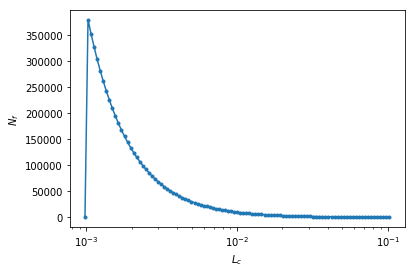

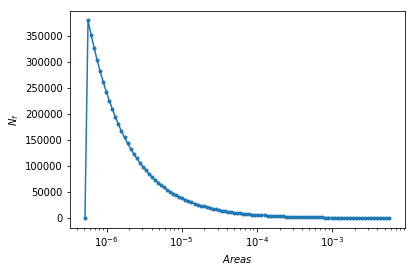

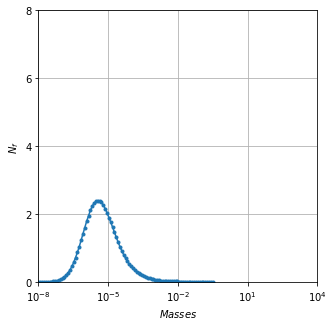

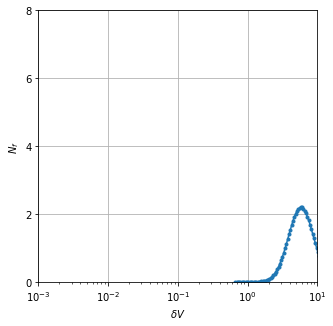

In [54]:
from numpy.random import uniform

bins = np.geomspace(0.001, 0.1, 100)
N_fragments = [number_fragments(b, 1000, 10, 10, True, debris_category.rb) / 10**5 for b in bins ]
N_fragments = (np.array(N_fragments) * 1e5).astype(int)

L_c = np.concatenate([uniform(bins[i], bins[i+1], size=N_fragments[i]) for i in range(len(bins) - 1)])
N_fragments_total = L_c.shape[0]
lambda_c = np.log10(L_c)
areas = avg_area(L_c)

def create_log_bins(values, nbins=100):
    #return np.geomspace(values.min(), values.max(), nbins)
    bins = np.geomspace(values.min(), values.max(), nbins)
    a = bins[1]/bins[0]
    bins = np.concatenate([[bins[0]/a], bins,[bins[-1]*a]])
    return bins

# Validating L_c
h, b = np.histogram(L_c, bins=create_log_bins(L_c))
plt.plot((b[:-1] + b[1:])/2, h, '.-')
plt.xscale('log')
plt.xlabel(r'$L_{c}$')
plt.ylabel(r'$N_f$')
plt.show()

# Validating Areas
h, b = np.histogram(areas, bins=create_log_bins(areas))
plt.plot((b[:-1] + b[1:])/2, h, '.-')
plt.xscale('log')
plt.xlabel(r'$Areas$')
plt.ylabel(r'$N_f$')
plt.show()

# Validating Mass & Velocity (Takes 5 min approx.)
AM = np.array(distribution_AM(N_fragments_total, lambda_c, debris_category.rb))
deltaV = np.array(distribution_deltaV(N_fragments_total, AM, 10, True))
AM = 10**AM
masses = areas / AM

h, b = np.histogram(masses, bins=create_log_bins(masses))
plt.figure(figsize=(5,5))
plt.plot((b[:-1] + b[1:])/2, h/1e5, '.-')
plt.xscale('log')
plt.xlabel(r'$Masses$')
plt.ylabel(r'$N_f$')
plt.gca().set_yticks([0, 2, 4, 6, 8])
plt.gca().set_xticks([1e-8, 1e-5, 1e-2, 10, 1e4])
plt.gca().set_xlim([1e-8,1e4])
plt.gca().set_ylim([0,8])
plt.grid()
plt.show()

h, b = np.histogram(deltaV, bins=create_log_bins(deltaV))
plt.figure(figsize=(5,5))
plt.plot((b[:-1] + b[1:])/2, h/1e5, '.-')
plt.xscale('log')
plt.xlabel(r'$\delta V$')
plt.ylabel(r'$N_f$')
plt.gca().set_yticks([0, 2, 4, 6, 8])
plt.gca().set_xticks([1e-3, 1e-2, 1e-1, 1, 10])
plt.gca().set_xlim([1e-3,10])
plt.gca().set_ylim([0,8])
plt.grid()
plt.show()

466.5682701802434

<h3>2.3 and Onward will be alternate breakup models</h3>

<h1>3. Numerical Propagation</h1>